In [183]:
import numpy as np
from qiskit.circuit.library import iqp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.providers.fake_provider import GenericBackendV2

# Let's create and run some circuit on 'ideal' simulator

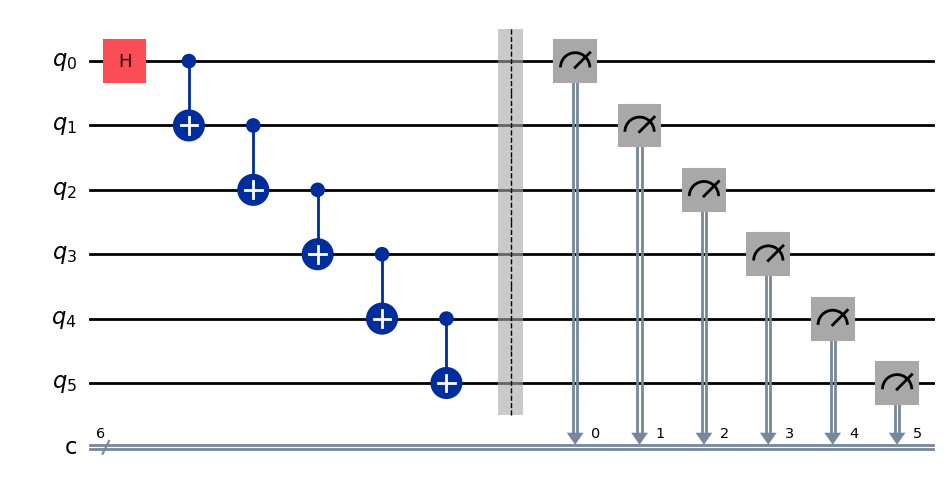

In [110]:
num_qubits=6
qc = QuantumCircuit(num_qubits, num_qubits)
qc.h(0)
for i in range(num_qubits-1):
    qc.cx(i, i + 1)

qc.barrier()

for i in range(num_qubits):
    qc.measure(i,i)

qc.draw('mpl')

In [111]:
ideal_simulator = AerSimulator()

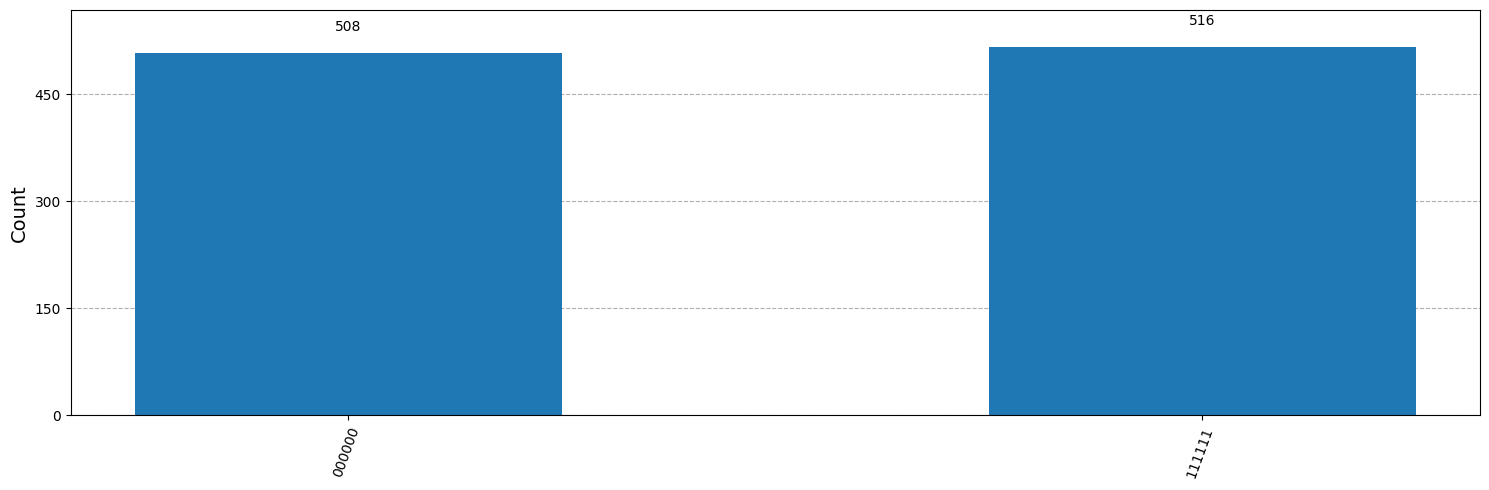

In [51]:
pm = generate_preset_pass_manager(backend=ideal_simulator)
qc_transpiled_ideal = pm.run(qc)
 
sampler = Sampler(ideal_simulator)

job = sampler.run([qc_transpiled_ideal])
result = job.result()
 
pub_result = result[0]
counts_ideal = pub_result.data.c.get_counts()

plot_histogram(counts_ideal, figsize=(15,5))

# Now, let's run it on realistic simulator (which simulates noise/errors of real backend)

In [40]:
noisy_simulator = FakeSherbrooke()

BTW - you can create your own noisy simulators: https://docs.quantum.ibm.com/guides/build-noise-models

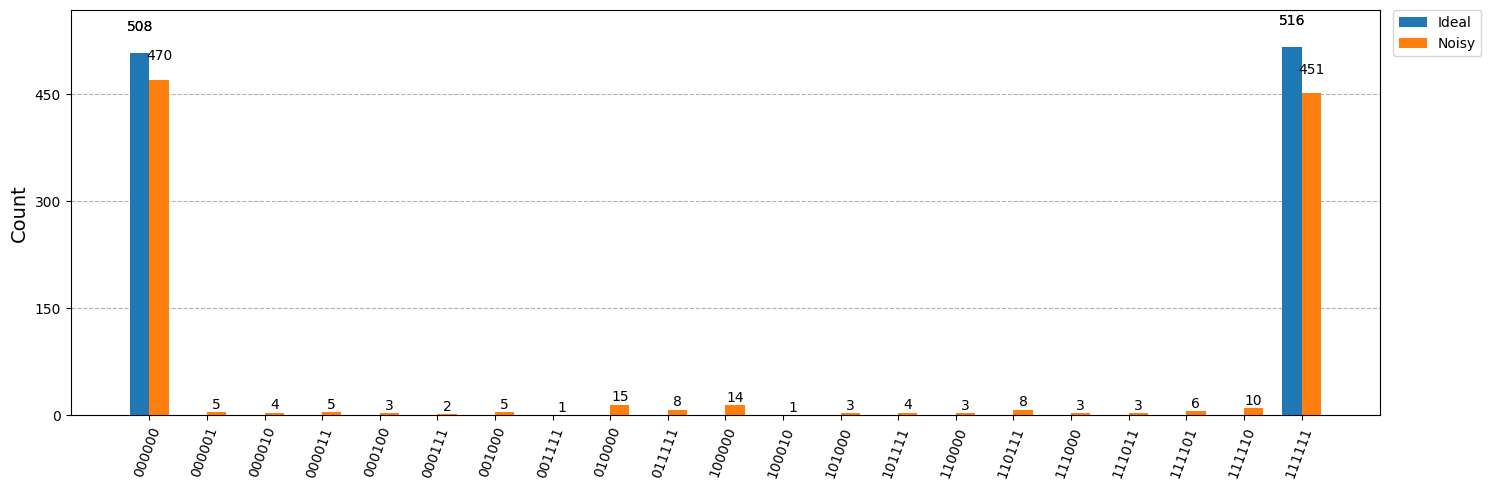

In [52]:
pm = generate_preset_pass_manager(backend=noisy_simulator)
qc_transpiled_noisy = pm.run(qc)
 
sampler = Sampler(noisy_simulator)

job = sampler.run([qc_transpiled_noisy])
result = job.result()
 
pub_result = result[0]
counts_noisy = pub_result.data.c.get_counts()

plot_histogram([counts_ideal, counts_noisy], legend=["Ideal", "Noisy"], figsize=(15,5))

# Now, let's run on actual real backend ;)

In [58]:
service = QiskitRuntimeService()
real_backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
print(real_backend)

C:\Users\P39686820\AppData\Local\Temp\ipykernel_14576\3876760891.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


<IBMBackend('ibm_sherbrooke')>


In [65]:
pm = generate_preset_pass_manager(backend=real_backend)
qc_transpiled_real = pm.run(qc)
 
sampler = Sampler(real_backend)

job = sampler.run([qc_transpiled_real], shots=1024)

In [66]:
job.status()

'DONE'

In [67]:
job.job_id()

'd09y72wd8drg008ypdb0'

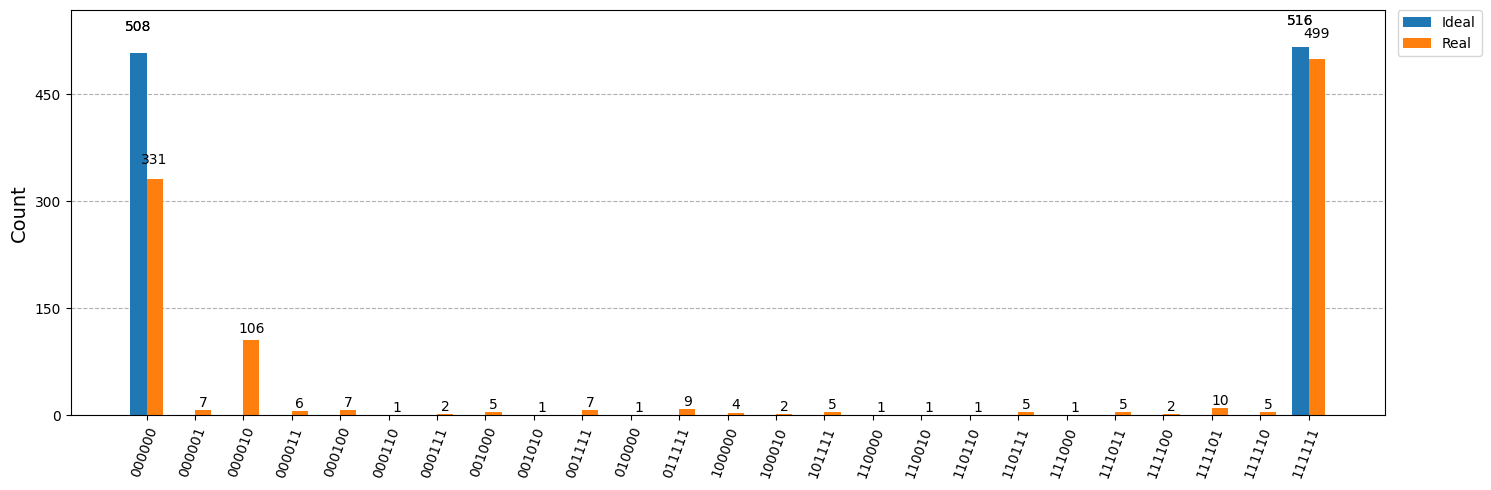

In [68]:
result = job.result()
 
pub_result = result[0]
counts_real = pub_result.data.c.get_counts()

plot_histogram([counts_ideal, counts_real], legend=["Ideal", "Real"], figsize=(15,5))

# There are ways to mitigate the errors, let's do that...

In [73]:
pm = generate_preset_pass_manager(backend=real_backend, optimization_level=3)
qc_transpiled_real_optimized = pm.run(qc)
 
sampler = Sampler(real_backend)
#These options work only on real backend - you can not use them on any simulators
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

job = sampler.run([qc_transpiled_real_optimized], shots=1024)

In [76]:
job.status()

'DONE'

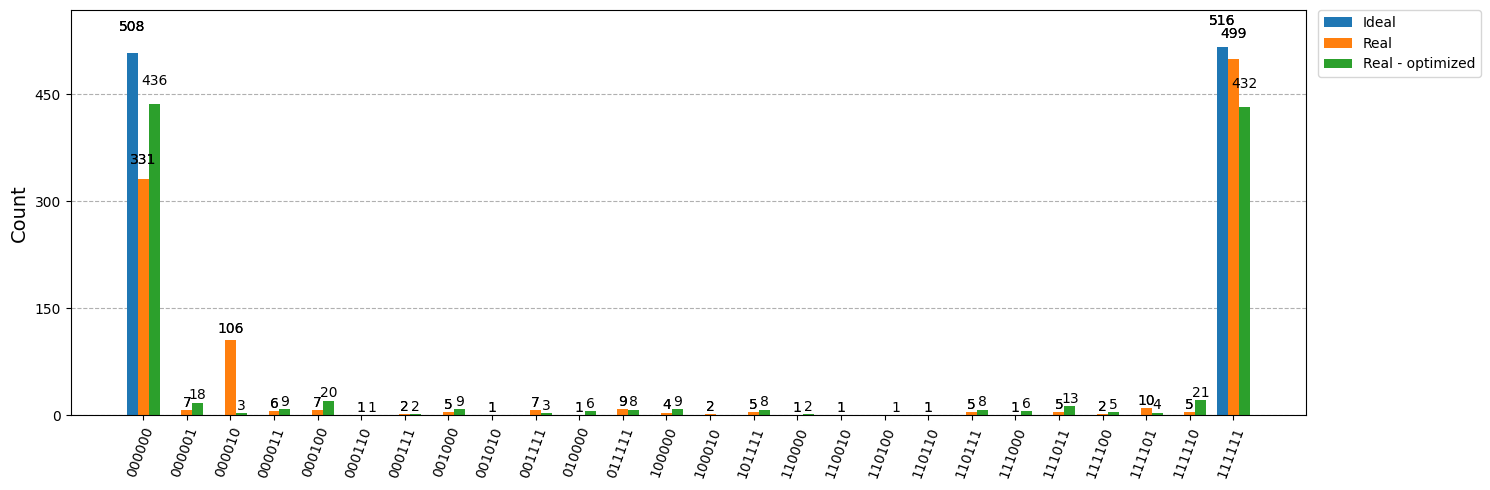

In [77]:
result = job.result()
 
pub_result = result[0]
counts_real_optimized = pub_result.data.c.get_counts()

plot_histogram([counts_ideal, counts_real, counts_real_optimized], legend=["Ideal", "Real", "Real - optimized"], figsize=(15,5))

We used:
* ```optimization_level```: https://docs.quantum.ibm.com/guides/set-optimization
* Error suppression: https://docs.quantum.ibm.com/guides/configure-error-suppression

In [91]:
from qiskit.quantum_info.analysis import hellinger_fidelity

print(hellinger_fidelity(counts_ideal, counts_real))
print(hellinger_fidelity(counts_ideal, counts_real_optimized))

0.8027868542744447
0.8476235566310845


# Transpilation

* transpilation is a process of reworking the circuit to a (mathematically equivalent) form which however can be physically executed on real backend
* not all gates are natively implemented and not all qubits are connected with each other - this makes the transpiled circuits much longer than orginal ones
* the more gates in the circuit, the more important transpilation is
* transpilation is NOT deterministic - when you run the same code multiple times, you can get different results (it's it practive a very complex process)
* there exists AI transpiler service, which uses AI to propose most optimal transpiler parameters

In [79]:
print(qc.depth())
print(qc.count_ops())
print(qc.num_nonlocal_gates())

7
OrderedDict([('measure', 6), ('cx', 5), ('h', 1), ('barrier', 1)])
5


In [80]:
print(qc_transpiled_real.depth())
print(qc_transpiled_real.count_ops())
print(qc_transpiled_real.num_nonlocal_gates())

19
OrderedDict([('rz', 21), ('sx', 12), ('measure', 6), ('ecr', 5), ('x', 3), ('barrier', 1)])
5


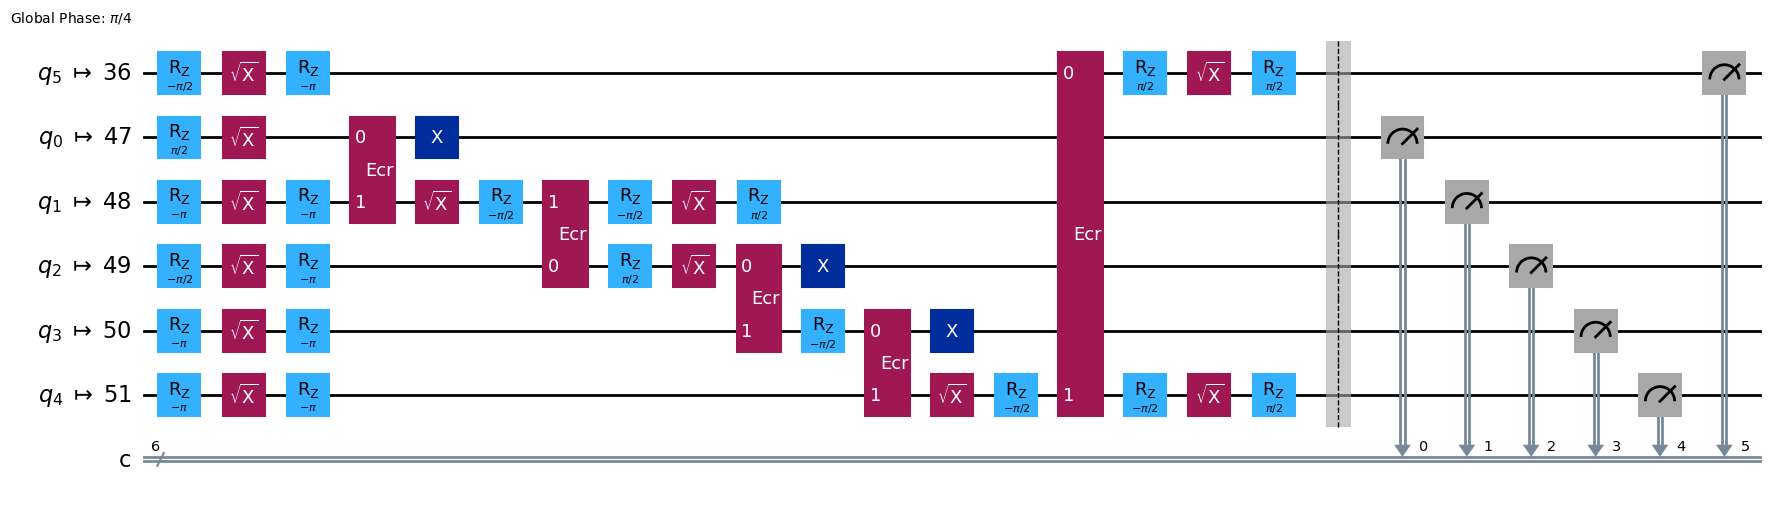

In [82]:
qc_transpiled_real.draw('mpl')

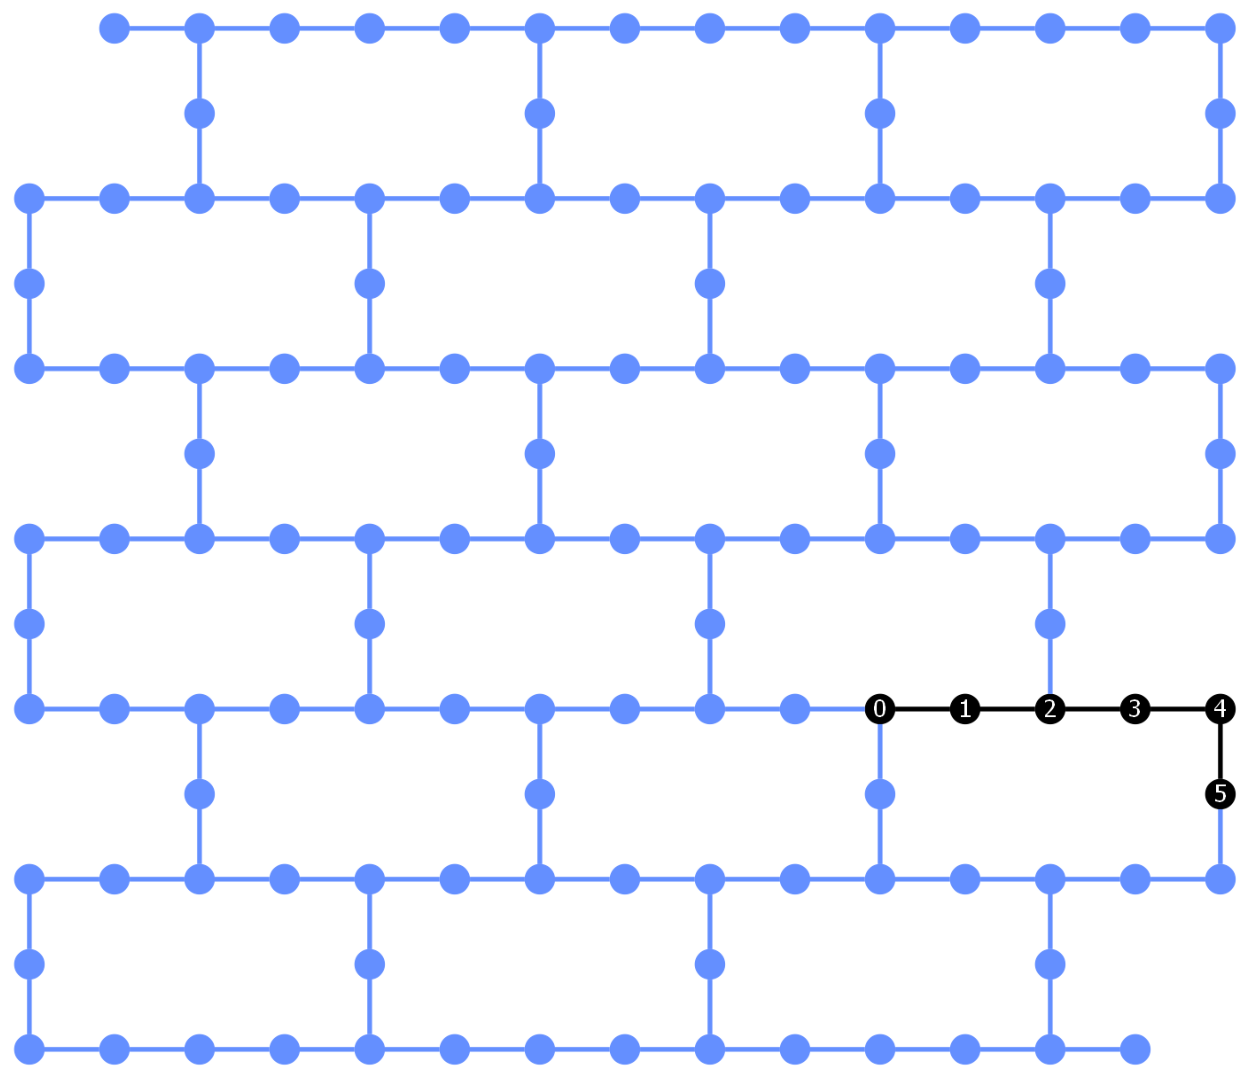

In [88]:
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(qc_transpiled_real, real_backend)

# Analyzing backend properties:

In [94]:
print(
    f"Name: {real_backend.name}\n"
    f"Version: {real_backend.version}\n"
    f"No. of qubits: {real_backend.num_qubits}\n"
)

Name: ibm_sherbrooke
Version: 2
No. of qubits: 127



In [95]:
real_backend.qubit_properties(0)

QubitProperties(t1=0.0003202004632733549, t2=0.0001287958986725291, frequency=4635640833.725592)

In [103]:
config = backend.configuration()

print("This backend is called {0}, and is in version {1}. It has {2} qubits.\n"
      "The basis gates supported on this device are {3}."
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                config.basis_gates))

This backend is called ibm_sherbrooke, and is in version 1.6.88. It has 127 qubits.
The basis gates supported on this device are ['ecr', 'id', 'rz', 'sx', 'x'].


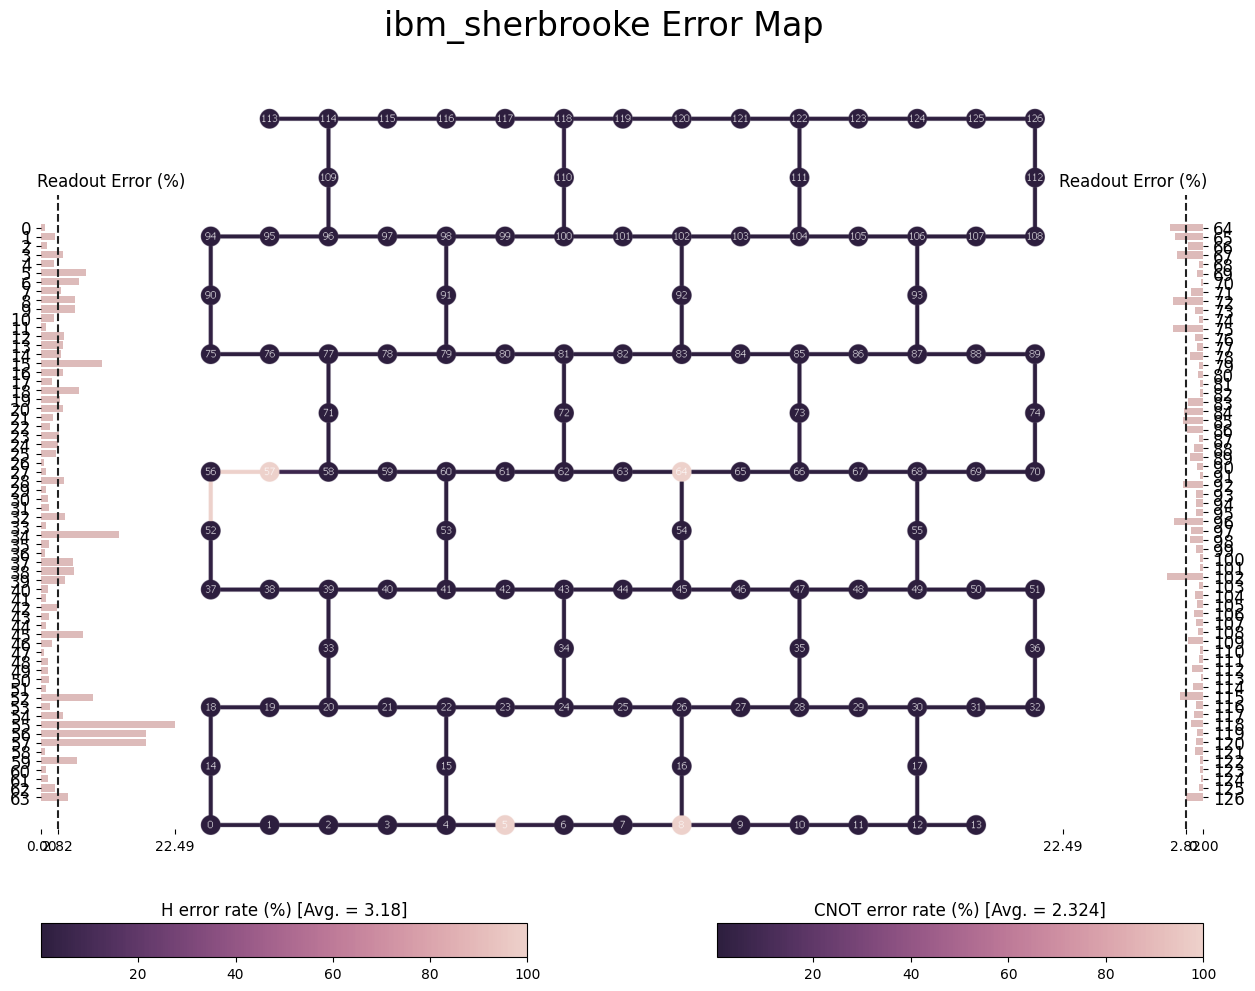

In [104]:
from qiskit.visualization import plot_error_map
plot_error_map(real_backend)

In [106]:
from pprint import pprint
pprint(vars(real_backend.properties()))

{'_data': {'general_qlists': [{'name': 'lf_4', 'qubits': [123, 122, 121, 120]},
                              {'name': 'lf_5',
                               'qubits': [120, 121, 122, 123, 124]},
                              {'name': 'lf_6',
                               'qubits': [124, 123, 122, 121, 120, 119]},
                              {'name': 'lf_7',
                               'qubits': [121, 122, 123, 124, 125, 126, 112]},
                              {'name': 'lf_8',
                               'qubits': [120,
                                          121,
                                          122,
                                          123,
                                          124,
                                          125,
                                          126,
                                          112]},
                              {'name': 'lf_9',
                               'qubits': [119,
                                      

In [115]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              properties.frequency(qubit) * GHz))

describe_qubit(0, real_backend.properties())

Qubit 0 has a 
  - T1 time of 320.2004632733549 microseconds
  - T2 time of 128.7958986725291 microseconds
  - U2 gate error of 0.00023333115521478092
  - U2 gate duration of 56.888888888888886 nanoseconds
  - resonant frequency of 4.635640833725592 GHz


# Exercise 1:
* Generate random circuit with width 10 and depth 10 (use random_circuit() function).
* Check depth and number of non-local gates before and after transpilation (on simulator and on real backend)
* Run it on ideal simulator and on real backend in such a way that Hellinger fidelity is maximal between simulator and backend results.
* Hints:
  * transpilation is a non-deterministic process
  * multiple-qubit controlled gates result in large number of 2-qubit gates

# Presentation on ZNE and roadmap

# Tuning Estimator

In [204]:
observable = SparsePauliOp.from_list([("XX", 1), ("ZI", 2)])

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0,1)

simulator = AerSimulator()
#simulator = GenericBackendV2(num_qubits=2)

#options = {"simulator": {"seed_simulator": 42}}
#estimator = Estimator(mode=simulator, options=options)
estimator = Estimator(mode=simulator)

pm = generate_preset_pass_manager(backend=simulator)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

job = estimator.run([(isa_circuit, isa_observable)])
pub_result = job.result()[0]
print(f">>> Expectation value: {pub_result.data.evs}")

>>> Expectation value: 1.03515625


In [193]:
estimator = StatevectorEstimator()
pm = generate_preset_pass_manager(optimization_level=3) #Note - we did not define backend for which we want to transpile
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

job = estimator.run([(isa_circuit, isa_observable)])
pub_result = job.result()[0]
print(f">>> Expectation value: {pub_result.data.evs}")

>>> Expectation value: 0.9999999999999998


# Exercise 2:
* Calculate expectation value on real backend of operator ```-1.123*IIII + 0.39*IZZI -0.39*ZZIZ -0.5*ZZYY+0.2*XXYY``` in 4-qubit GHZ state
* Use all the error mitigation techniques possible
* Compare expectation value obtained using ideal simulator and backend without error mitigation
* Reference to this guide regarding error mitigation techniques https://docs.quantum.ibm.com/guides/configure-error-mitigation (you can read more on the techniques used here https://docs.quantum.ibm.com/guides/error-mitigation-and-suppression-techniques)

# Homework:
* watch the 30 minute video on a famous IBM paper in Nature demonstrating getting real value from noise quantum computers: https://www.youtube.com/watch?app=desktop&v=CWn5tv9CgBg&sf182528027=1
* I highly recommend to also read the original paper: https://www.nature.com/articles/s41586-023-06096-3